# Studying the influence of randomness in the data split and machine settings

By data split, the parameter random_state in `train_test_split()` could yield to suboptimal data split which could lead to suboptimal solution. 
In this small experiment, I have used a small dataset, to identify if setting the machine `seed` or `random_state` influences the model predictions. 

In [28]:
import pandas as pd 
import seaborn as sns 
import random 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm

In [29]:
# helpers 

def get_metrics(X, y, state, model):
    if state is None:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=state)

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc  = accuracy_score(y_test, preds)
    return acc

def plot_results(df, column_names=None, condition=None, figsize = (12,6)):

    if column_names is None:
        column_names = df.columns

    total_columns = len(column_names)
    plt.figure(figsize=figsize)        
    plt.suptitle(condition)
    for ix in range(1, total_columns+1):
        plt.subplot(total_columns, 1, ix)
        data_points = df[column_names[ix-1]]
        mu = data_points.mean()
        sig = data_points.std() 
        lower_bound = mu - 3*sig 
        upper_bound = mu + 3*sig
        sns.scatterplot(data_points)
        plt.axhline(y = lower_bound, color = 'r', linestyle = '--')
        plt.axhline(y = upper_bound, color = 'r', linestyle = '--')
        plt.fill_between([0, df.shape[0]], lower_bound, upper_bound, color='g', alpha=0.25, linestyle='--', linewidth=2)

In [30]:
df = pd.read_csv('datasets/winequality-red.csv')
X = df.drop("quality", axis=1)
df['quality'] = df['quality'].apply(lambda x: 1 if x>5 else 0)
y = df['quality']
df.head() 

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


<Axes: xlabel='quality', ylabel='count'>

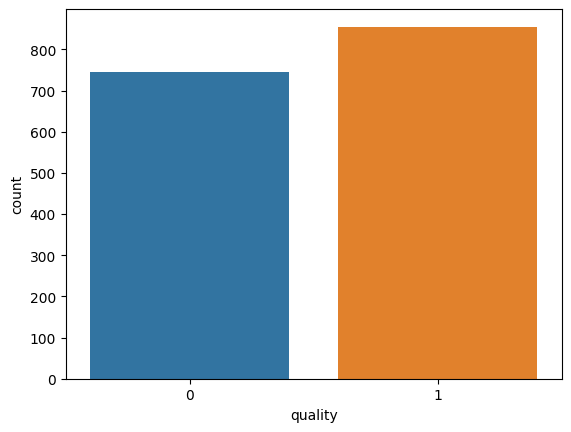

In [31]:
sns.countplot(data=df, x='quality')

Since the classes are imbalanced, we will create statified train test split
We will do 500 simulations to study the fluctuations in the prediction capabilities
    - since this is a multi-class classification, we will use Accuracy measure as our metric
    - we will set up 3 models Non_parametric, non-parametric ensemble and Parametric models 
        - randomForest : non-parametric ensemble
        - Logistic regression : parametric
        - DecisionTree : non-parametric


In [32]:
low = 1 
high = 1000 
num_seeds = 500

# Vanilla Setting : without those paarameters 

In [33]:
results = [] 

for ix in tqdm(range(num_seeds)):

    # logistic 
    model = LogisticRegression(max_iter=100000) 
    acc_logistic = get_metrics(X, y, state=None, model=model)

    # Dtree 
    model = DecisionTreeClassifier()
    acc_dtree  = get_metrics(X, y, state=None, model=model)
    
    # RF 
    model = RandomForestClassifier() 
    acc_rf = get_metrics(X, y, state=None, model=model)

    results.append([acc_logistic, acc_rf, acc_dtree])



100%|██████████| 500/500 [08:31<00:00,  1.02s/it]


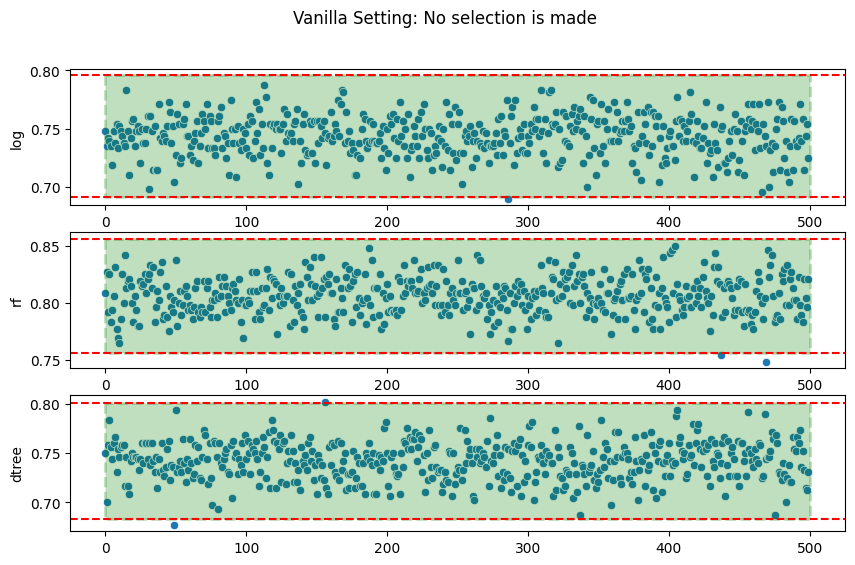

In [34]:
results_df = pd.DataFrame(results, columns=['log', 'rf','dtree'])
plot_results(df=results_df, column_names=['log', 'rf','dtree'], condition="Vanilla Setting: No selection is made", figsize = (10,6))

# Fixed: state and Seed

100%|██████████| 500/500 [08:36<00:00,  1.03s/it]


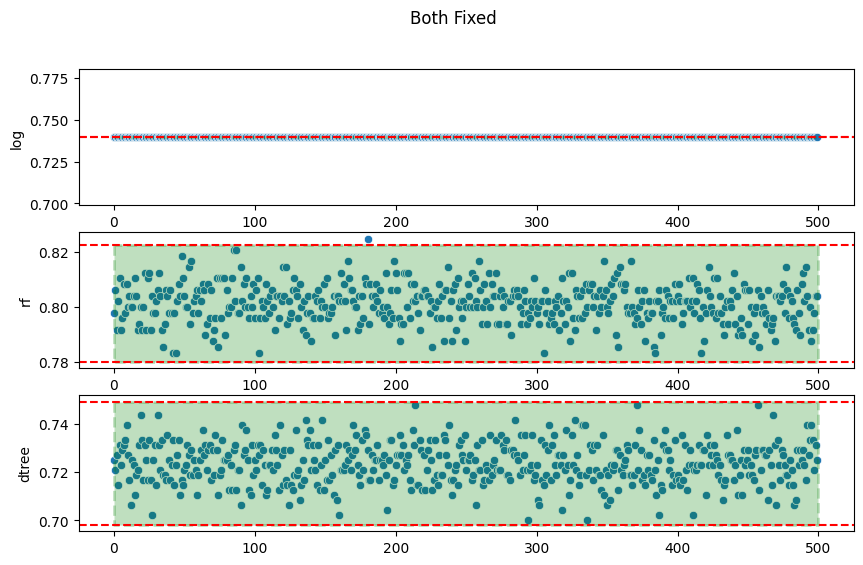

In [35]:
results = [] 

seed = random.randint(a=low, b=high**2)
state = random.randint(a=low, b=high**2)

for ix in tqdm(range(num_seeds)):
    random.seed(seed) 

    # logistic 
    model = LogisticRegression(max_iter=100000) 
    acc_logistic = get_metrics(X, y, state, model)

    # Dtree 
    model = DecisionTreeClassifier()
    acc_dtree  = get_metrics(X, y, state, model)
    
    # RF 
    model = RandomForestClassifier() 
    acc_rf = get_metrics(X, y, state, model)

    results.append([seed, state, acc_logistic, acc_rf, acc_dtree])

results_df = pd.DataFrame(results, columns=['seed','state','log', 'rf','dtree'])
plot_results(df=results_df, column_names=['log', 'rf','dtree'], condition="Both Fixed", figsize = (10,6))

# seed fixed, state random 

100%|██████████| 500/500 [07:32<00:00,  1.11it/s]


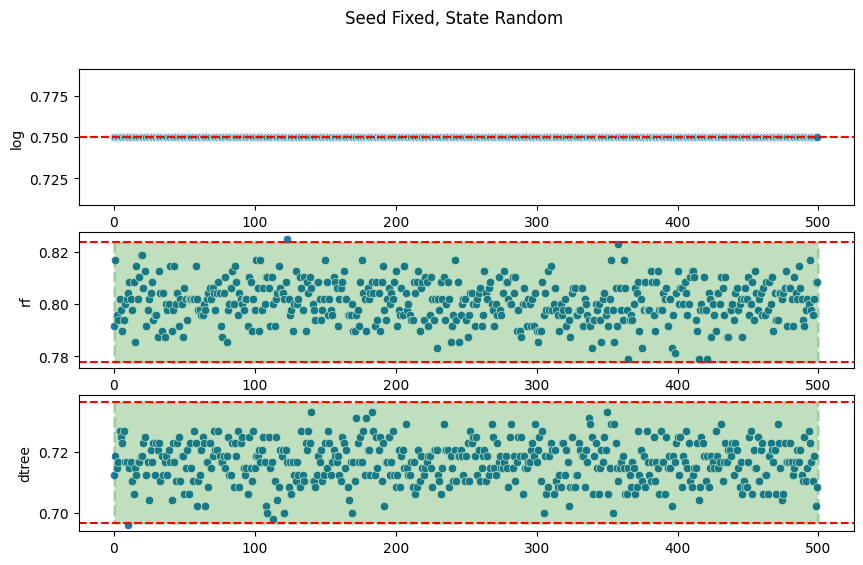

In [36]:
results = [] 

seed = random.randint(a=low, b=high**2)

for ix in tqdm(range(num_seeds)):
    random.seed(seed) 
    state = random.randint(a=low, b=high**2)
    
    # logistic 
    model = LogisticRegression(max_iter=100000) 
    acc_logistic = get_metrics(X, y, state, model)

    # Dtree 
    model = DecisionTreeClassifier()
    acc_dtree  = get_metrics(X, y, state, model)
    
    # RF 
    model = RandomForestClassifier() 
    acc_rf = get_metrics(X, y, state, model)

    results.append([seed, state, acc_logistic, acc_rf, acc_dtree])

results_df = pd.DataFrame(results, columns=['seed','state','log', 'rf','dtree'])
plot_results(df=results_df, column_names=['log', 'rf','dtree'], condition="Seed Fixed, State Random", figsize = (10,6))

# Seed Random, state fixed

100%|██████████| 500/500 [08:40<00:00,  1.04s/it]


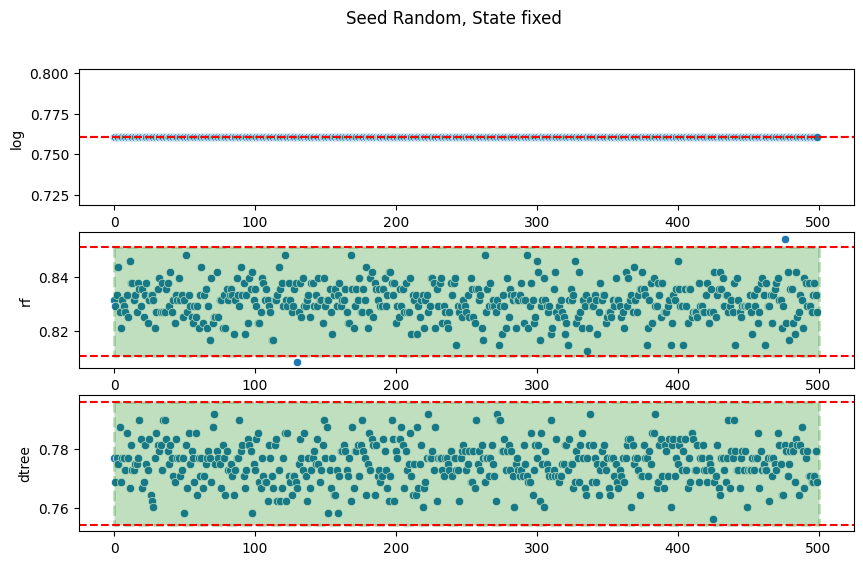

In [37]:
results = [] 

state = random.randint(a=low, b=high**2)

for ix in tqdm(range(num_seeds)):
    seed = random.randint(a=low, b=high**2)
    random.seed(seed) 
    
    # logistic 
    model = LogisticRegression(max_iter=100000) 
    acc_logistic = get_metrics(X, y, state, model)

    # Dtree 
    model = DecisionTreeClassifier()
    acc_dtree  = get_metrics(X, y, state, model)
    
    # RF 
    model = RandomForestClassifier() 
    acc_rf = get_metrics(X, y, state, model)

    results.append([seed, state, acc_logistic, acc_rf, acc_dtree])

results_df = pd.DataFrame(results, columns=['seed','state','log', 'rf','dtree'])
plot_results(df=results_df, column_names=['log', 'rf','dtree'], condition="Seed Random, State fixed", figsize = (10,6))

# both random

100%|██████████| 500/500 [57:10<00:00,  6.86s/it]    


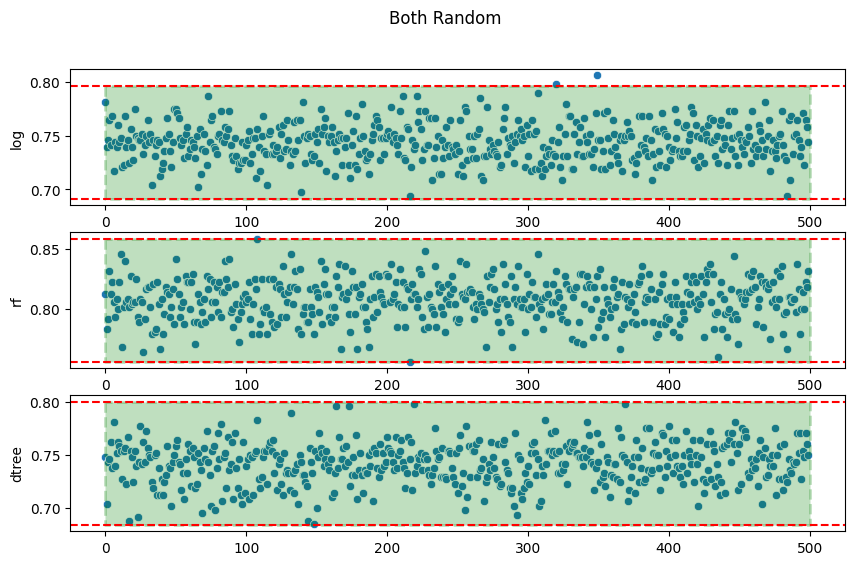

In [38]:
results = []

for ix in tqdm(range(num_seeds)):
    state = random.randint(a=low, b=high**2)
    seed = random.randint(a=low, b=high**2)
    
    random.seed(seed) 
    
    # logistic 
    model = LogisticRegression(max_iter=100000) 
    acc_logistic = get_metrics(X, y, state, model)

    # Dtree 
    model = DecisionTreeClassifier()
    acc_dtree  = get_metrics(X, y, state, model)
    
    # RF 
    model = RandomForestClassifier() 
    acc_rf = get_metrics(X, y, state, model)

    results.append([seed, state, acc_logistic, acc_rf, acc_dtree])

results_df = pd.DataFrame(results, columns=['seed','state','log', 'rf','dtree'])
plot_results(df=results_df, column_names=['log', 'rf','dtree'], condition="Both Random", figsize = (10,6))